# SERS spectra classification 
This notebook provides an extensive workflow realized using BoxSERS for the classification of spectra with a CNN deep learning model 

In [1]:
from sklearn.preprocessing import LabelBinarizer
import pandas as pd
from sklearn.utils import shuffle
from boxsers import data_split
from boxsers.visual_tools import distribution_plot, spectro_plot
from boxsers.preprocessing import savgol_smoothing, als_baseline_cor, spectral_normalization, cosmic_filter, spectral_cut
from boxsers.data_augmentation import aug_noise, aug_mixup, aug_linslope, aug_xshift
from boxsers import SpectroCNN
from boxsers.machine_learning import SpectroLDA, SpectroRF, SpectroSVM, SpectroCNN, validation_metrics

import matplotlib.pyplot as plt
import numpy as np

## Database importation and label encoding

---

**Important Function/Class used :** 
- ``LabelBinarizer`` (class from Scikit Learn): Converts label to binary label matrix.

**Comments :**
 - The labels occupy the first column (column 0) of the dataframe, which can be addressed by its tag 'Classes'.
 - The spectra occupy the remaining columns of the dataframe, the associated coordinates are therefore [0: , 1:].

In [2]:
df = pd.read_hdf('Bile_acids_27_07_2020.h5', key='df')  # Load bile acids dataframe
wn = np.load('Raman_shift_27_07_2020.npy')  # Load Wavenumber (Raman shift)
classnames = df['Classes'].unique()  

display(df)  # Prints a detailed overview of the imported dataframe "df"

# Features extraction: Exports dataframe spectra as a numpy array (value type = float64).
sp = df.iloc[:, 1:].to_numpy()
# Labels extraction: Export dataframe classes into a numpy array of string values.
label = df.loc[:, 'Classes'].values

# Creating instance of LabelBinarizer
labelbinarizer = LabelBinarizer()

# Encodes labels (value type = string) as binary label [1 0 0 0] [0 0 0 1] [0 1 0 0], ...
lab_binary = labelbinarizer.fit_transform(label)

,Classes,0,1,2,3,4,5,6,7,8,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,Blank,14698.0,14600.0,14933.0,15008.0,14864.0,14869.0,14982.0,14968.0,15026.0,...,5813.0,5717.0,5795.0,5865.0,5648.0,5667.0,5656.0,5764.0,5741.0,5807.0
1,Blank,14622.0,14329.0,14766.0,15041.0,14927.0,14907.0,14783.0,15076.0,15234.0,...,5778.0,5897.0,5735.0,5778.0,5695.0,5734.0,5627.0,5845.0,5666.0,5805.0
2,Blank,15225.0,15343.0,15557.0,15533.0,15518.0,15601.0,15366.0,15541.0,15645.0,...,5617.0,5574.0,5801.0,5672.0,5629.0,5648.0,5608.0,5690.0,5744.0,5726.0
3,Blank,15052.0,14922.0,15215.0,15310.0,15437.0,15208.0,15166.0,15625.0,15499.0,...,5740.0,5808.0,5958.0,5881.0,5828.0,5757.0,5877.0,5826.0,5822.0,5785.0
4,Blank,14211.0,14370.0,14346.0,14550.0,14601.0,14521.0,14431.0,14757.0,14741.0,...,5558.0,5607.0,5706.0,5747.0,5604.0,5546.0,5563.0,5682.0,5558.0,5543.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4795,TCDCA,13532.0,13549.0,13639.0,13916.0,13721.0,13758.0,13736.0,13828.0,13827.0,...,5694.0,5746.0,5649.0,5562.0,5608.0,5601.0,5603.0,5616.0,5528.0,5611.0
4796,TCDCA,13277.0,13086.0,13472.0,13415.0,13415.0,13459.0,13657.0,13387.0,13615.0,...,5743.0,5801.0,5769.0,5669.0,5639.0,5709.0,5718.0,5743.0,5768.0,5616.0
4797,TCDCA,14002.0,13930.0,13961.0,14149.0,14165.0,14155.0,14292.0,14107.0,14119.0,...,5679.0,5670.0,5718.0,5721.0,5578.0,5639.0,5596.0,5614.0,5637.0,5614.0
4798,TCDCA,14140.0,14022.0,14204.0,14271.0,14285.0,14313.0,14375.0,14258.0,14522.0,...,5936.0,6091.0,5975.0,6084.0,5859.0,5919.0,5950.0,5957.0,5997.0,5910.0


## Preprocessing of spectra

---

**Important functions used :**
1. `cosmic_filter` : Applies a median filter to remove cosmic rays from the spectrum(s).
2. `als_baseline_cor` : Subtracts the baseline signal from the spectrum(s) using Asymmetric Least Squares estimation.
3. `savgol_smoothing` : Smoothes the spectrum(s) using a Savitzky-Golay polynomial filter.
4. `spectral_normalization` : Normalizes the spectrum(s) using one of the three available norms ( L2, L1, maxmin)
 - ``spectro_plot`` : Returns a plot with the selected spectrum(s)


**Comments** :

- The spectrum pre-processing sequence used here can be changed.

- Some functions are not presented, but remain accessible from the _preprocessing.py_ module :
    - ``spline_interpolation`` : Performs a one-dimensional interpolation spline on the spectra to reproduce them with a new X-axis.  


- Write ``help(name of the function or the class)`` to get more information, namely on the parameters. 


In [3]:
def preprocessing_method(x, w):
    # 1) Applies a median filter to remove cosmic rays from the spectrum(s).
    x = cosmic_filter(x, ks=3)
    # 2) Smoothes the spectra
    x = savgol_smoothing(x, 7, p=3, degree=0)
    # 3) Subtracts the baseline signal from the spectrum(s) using Asymmetric Least Squares estimation.
    x = als_baseline_cor(x, lam=1e4, p=0.001)
    # 3) Normalizes the spectra 
    x = spectral_normalization(x, norm='l2')
    return x, w


sp_p, wn_p = preprocessing_method(sp, wn)  # spectra preprocessing

Row corresponding to the spectrum in the database:  130
Corresponding bile acid:  Blank


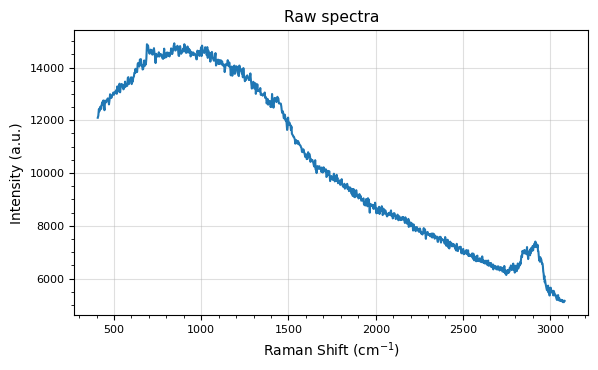

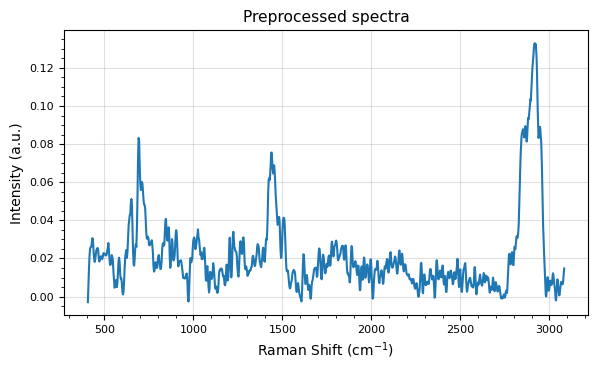

In [4]:
# A spectrum is selected randomly and plotted
random_index = np.random.randint(0, sp_p.shape[0]-1)
label_a = label[random_index]  # class corresponding to the first spectrum

print('Row corresponding to the spectrum in the database: ', random_index)
print('Corresponding bile acid: ', label_a)

# Graphs visualization : 
spectro_plot(wn, sp[random_index], title='Raw spectra')
spectro_plot(wn_p, sp_p[random_index], title='Preprocessed spectra')

## Train / Val / Test subsets split
----------------------------------

**Important Function/Class used :** 
   - ``data_split`` : Randomly splits an initial set of spectra into two new subsets named in this function: subset A and subset B.
   - ``distribution_plot`` : Return a bar plot that represents the distributions of spectra for each classes in a given set of spectra.
   

**Comments :**
- In this example, the initial set of spectra is divided according to the following proportions: 70% of the spectra for the training   set, 15% for the validation set and 15% for the test set.
- Write ``help(name of the function or the class)`` to get more information, namely on the parameters. 

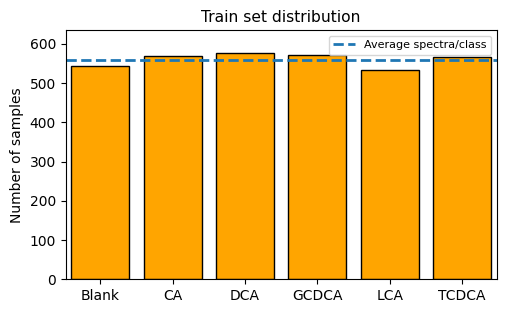

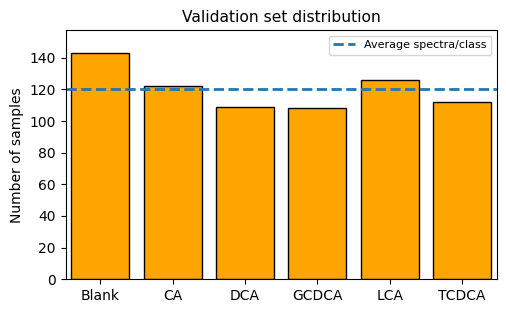

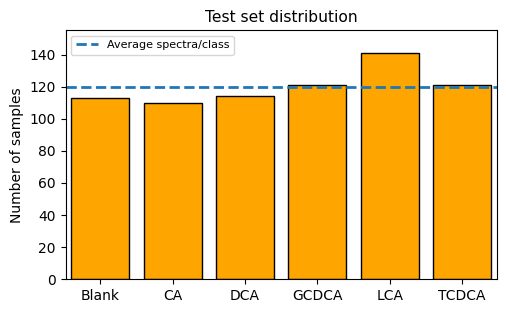

In [5]:
(sp_train, sp_b, lab_train, lab_b) = data_split(sp_p, lab_binary, b_size=0.30, rdm_ste=1, print_report=False)

(sp_val, sp_test, lab_val, lab_test) = data_split(sp_b, lab_b, b_size=0.50, rdm_ste=60, print_report=False)

distribution_plot(lab_train, class_names=classnames, avg_line=True, title='Train set distribution')
distribution_plot(lab_val, class_names=classnames, avg_line=True, title='Validation set distribution')
distribution_plot(lab_test, class_names=classnames, avg_line=True, title='Test set distribution')

## Data augmentation pipeline

---

**Important Function/Class used :** 
   - ``aug_noise`` : Generates new spectra by adding random noise
   - ``aug_xshift`` : Generates new spectra with pixel shifts
   - ``aug_offset`` : Generates new spectra by adding an intensity offset
   - ``aug_multiplier`` : Generates new spectra by adding multiplicative factors
   - ``aug_linslope`` : Generates new spectra by the addition of a linear slopes
   - ``aug_mixup`` : Generates new spectra using a linear combinaison process inspired by (Zhang, Hongyi, et al. 2017).


**Comments :**
- Write ``help(name of the function or the class)`` to get more information, namely on the parameters. 

In [6]:
def data_aug_pipeline(x, y, i):
    """ pipeline with several data augmentation methods adapted for spectra."""
    # new specta are generated
    x_nse_u, y_nse_u = aug_noise(x, y, snr=15, noise_type='uniform', quantity=i)
    x_nse_p, y_nse_p = aug_noise(x, y, snr=15, noise_type='proportional', quantity=i)
    x_wshft, y_wshft = aug_xshift(x, y, xshift_range=5, quantity=i)
    x_mixup, y_mixup = aug_mixup(x, y, n_spec=2, alpha=0.35, quantity=i) 

    # stacks all generated spectra and originals in a single array
    x_aug = np.vstack((x, x_nse_u, x_nse_p, x_wshft, x_mixup))
    y_aug = np.vstack((y, y_nse_u, y_nse_p, y_wshft, y_mixup))

    # spectra and labels are randomly mixed two times
    x_aug, y_aug = shuffle(x_aug, y_aug, random_state=22)
    x_aug, y_aug = shuffle(x_aug, y_aug, random_state=24)
    return x_aug, y_aug

# retrieving augmented data
data_aug_fold = 3
sp_train_aug, lab_train_aug = data_aug_pipeline(sp_train, lab_train, data_aug_fold)

print('spectra before/after shapes =', sp_train.shape, '/', sp_train_aug.shape)
print('label before/after shapes =', lab_train.shape, '/', lab_train_aug.shape)

spectra before/after shapes = (3360, 1024) / (43680, 1024)
label before/after shapes = (3360, 6) / (43680, 6)


## Convolutionnal neural network (CNN) implementation & training

---

**Important Function/Class used :** 
   - ``SpectroCNN`` : Convolutional Neural Network (CNN) for vibrational spectra classification.
       - ``compile_model`` : Compile the CNN model with the latest changes made to the model.
       - ``config_earlystopping`` : Configures an early stopping during the CNN model training.
       - ``config_modelcheckpoint`` : Configures a checkpoint during CNN model training.
       - ``print_info`` : Prints CNN model information.
       - ``train_model`` :Train the model on a given set of spectra

**Comments :**
- In this example, we have trained our CNN with the following hyperparameters:
    - Kernel filter size = 5
    - Dropout rate = 0.45 
    - Hidden layer activation function = ReLU
    - Optimizer =  adam 
    - Learning rate = 1E-5
    - mode = 'multiclass' wich set the output activation function to softmax.
    - Loss funtion = 'categorical' wich corresponds to keras CategoricalCrossentropy loss. For two classes classification, use 'binary' instead.
    - Number of epoch for the training = 50 epochs
    - Batch size = 132
- Write ``help(name of the function or the class)`` to get more information, namely on the parameters. 

In [7]:
# Creating instance of SpectroCNN
CNN = SpectroCNN(shape_in=sp_train_aug.shape[1],  # lenght of the spectra, in this case 1024
                 shape_out=lab_train_aug.shape[1],  # number of classes
                 ks=5,  # kernel filter size 
                 dropout_rate=0.45,  # rate of the dropout during the training 
                 mode='multiclass',  # defines the CNN output activation function, multiclass == 'softmax' 
                 hidden_activation='relu')

# model compilation
CNN.compile_model(optimizer='adam',
                  learning_rate=1E-5,
                  loss_function='categorical')


# stores the model state with the best score according to the selected criterion and uploads it at the end of the training process.
CNN.config_modelcheckpoint(monit='val_acc') 

# print model structure
CNN.print_info(structure=True, hyperparameters=False)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1024, 1)]         0         
                                                                 
 conv_0 (Conv1D)             (None, 1024, 6)           36        
                                                                 
 batch_normalization (BatchN  (None, 1024, 6)          24        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 1024, 6)           0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 512, 6)           0         
 )                                                               
                                                                 
 conv_1 (Conv1D)             (None, 512, 12)           372   

Epoch 1/50
331/331 [==============================] - ETA: 0s - loss: 1.4770 - acc: 0.4617
Epoch 1: val_acc improved from -inf to 0.17500, saving model to best_model
INFO:tensorflow:Assets written to: best_model\assets


INFO:Assets written to: best_model\assets


331/331 [==============================] - 19s 46ms/step - loss: 1.4770 - acc: 0.4617 - val_loss: 2.6207 - val_acc: 0.1750
Epoch 2/50
330/331 [============================>.] - ETA: 0s - loss: 0.8310 - acc: 0.7149
Epoch 2: val_acc improved from 0.17500 to 0.75278, saving model to best_model
INFO:tensorflow:Assets written to: best_model\assets


INFO:Assets written to: best_model\assets


331/331 [==============================] - 15s 44ms/step - loss: 0.8307 - acc: 0.7150 - val_loss: 0.7263 - val_acc: 0.7528
Epoch 3/50
331/331 [==============================] - ETA: 0s - loss: 0.6204 - acc: 0.7974
Epoch 3: val_acc improved from 0.75278 to 0.88750, saving model to best_model
INFO:tensorflow:Assets written to: best_model\assets


INFO:Assets written to: best_model\assets


331/331 [==============================] - 15s 44ms/step - loss: 0.6204 - acc: 0.7974 - val_loss: 0.3335 - val_acc: 0.8875
Epoch 4/50
331/331 [==============================] - ETA: 0s - loss: 0.5134 - acc: 0.8400
Epoch 4: val_acc improved from 0.88750 to 0.90556, saving model to best_model
INFO:tensorflow:Assets written to: best_model\assets


INFO:Assets written to: best_model\assets


331/331 [==============================] - 15s 44ms/step - loss: 0.5134 - acc: 0.8400 - val_loss: 0.2741 - val_acc: 0.9056
Epoch 5/50
331/331 [==============================] - ETA: 0s - loss: 0.4402 - acc: 0.8728
Epoch 5: val_acc improved from 0.90556 to 0.92500, saving model to best_model
INFO:tensorflow:Assets written to: best_model\assets


INFO:Assets written to: best_model\assets


331/331 [==============================] - 15s 44ms/step - loss: 0.4402 - acc: 0.8728 - val_loss: 0.2349 - val_acc: 0.9250
Epoch 6/50
330/331 [============================>.] - ETA: 0s - loss: 0.3865 - acc: 0.8956
Epoch 6: val_acc improved from 0.92500 to 0.93056, saving model to best_model
INFO:tensorflow:Assets written to: best_model\assets


INFO:Assets written to: best_model\assets


331/331 [==============================] - 14s 44ms/step - loss: 0.3866 - acc: 0.8956 - val_loss: 0.2107 - val_acc: 0.9306
Epoch 7/50
331/331 [==============================] - ETA: 0s - loss: 0.3509 - acc: 0.9100
Epoch 7: val_acc improved from 0.93056 to 0.93333, saving model to best_model
INFO:tensorflow:Assets written to: best_model\assets


INFO:Assets written to: best_model\assets


331/331 [==============================] - 14s 44ms/step - loss: 0.3509 - acc: 0.9100 - val_loss: 0.1886 - val_acc: 0.9333
Epoch 8/50
331/331 [==============================] - ETA: 0s - loss: 0.3224 - acc: 0.9212
Epoch 8: val_acc improved from 0.93333 to 0.93611, saving model to best_model
INFO:tensorflow:Assets written to: best_model\assets


INFO:Assets written to: best_model\assets


331/331 [==============================] - 15s 45ms/step - loss: 0.3224 - acc: 0.9212 - val_loss: 0.1794 - val_acc: 0.9361
Epoch 9/50
330/331 [============================>.] - ETA: 0s - loss: 0.2967 - acc: 0.9309
Epoch 9: val_acc improved from 0.93611 to 0.94306, saving model to best_model
INFO:tensorflow:Assets written to: best_model\assets


INFO:Assets written to: best_model\assets


331/331 [==============================] - 15s 44ms/step - loss: 0.2965 - acc: 0.9310 - val_loss: 0.1658 - val_acc: 0.9431
Epoch 10/50
331/331 [==============================] - ETA: 0s - loss: 0.2811 - acc: 0.9375
Epoch 10: val_acc improved from 0.94306 to 0.94722, saving model to best_model
INFO:tensorflow:Assets written to: best_model\assets


INFO:Assets written to: best_model\assets


331/331 [==============================] - 15s 45ms/step - loss: 0.2811 - acc: 0.9375 - val_loss: 0.1586 - val_acc: 0.9472
Epoch 11/50
331/331 [==============================] - ETA: 0s - loss: 0.2648 - acc: 0.9448
Epoch 11: val_acc improved from 0.94722 to 0.95000, saving model to best_model
INFO:tensorflow:Assets written to: best_model\assets


INFO:Assets written to: best_model\assets


331/331 [==============================] - 15s 45ms/step - loss: 0.2648 - acc: 0.9448 - val_loss: 0.1506 - val_acc: 0.9500
Epoch 12/50
331/331 [==============================] - ETA: 0s - loss: 0.2510 - acc: 0.9496
Epoch 12: val_acc did not improve from 0.95000
331/331 [==============================] - 12s 36ms/step - loss: 0.2510 - acc: 0.9496 - val_loss: 0.1516 - val_acc: 0.9458
Epoch 13/50
330/331 [============================>.] - ETA: 0s - loss: 0.2403 - acc: 0.9533
Epoch 13: val_acc did not improve from 0.95000
331/331 [==============================] - 12s 36ms/step - loss: 0.2404 - acc: 0.9533 - val_loss: 0.1484 - val_acc: 0.9500
Epoch 14/50
331/331 [==============================] - ETA: 0s - loss: 0.2312 - acc: 0.9580
Epoch 14: val_acc improved from 0.95000 to 0.95278, saving model to best_model
INFO:tensorflow:Assets written to: best_model\assets


INFO:Assets written to: best_model\assets


331/331 [==============================] - 14s 44ms/step - loss: 0.2312 - acc: 0.9580 - val_loss: 0.1427 - val_acc: 0.9528
Epoch 15/50
331/331 [==============================] - ETA: 0s - loss: 0.2201 - acc: 0.9614
Epoch 15: val_acc did not improve from 0.95278
331/331 [==============================] - 12s 36ms/step - loss: 0.2201 - acc: 0.9614 - val_loss: 0.1407 - val_acc: 0.9514
Epoch 16/50
330/331 [============================>.] - ETA: 0s - loss: 0.2135 - acc: 0.9632
Epoch 16: val_acc did not improve from 0.95278
331/331 [==============================] - 12s 36ms/step - loss: 0.2135 - acc: 0.9632 - val_loss: 0.1377 - val_acc: 0.9514
Epoch 17/50
330/331 [============================>.] - ETA: 0s - loss: 0.2064 - acc: 0.9666
Epoch 17: val_acc improved from 0.95278 to 0.95556, saving model to best_model
INFO:tensorflow:Assets written to: best_model\assets


INFO:Assets written to: best_model\assets


331/331 [==============================] - 15s 45ms/step - loss: 0.2063 - acc: 0.9666 - val_loss: 0.1362 - val_acc: 0.9556
Epoch 18/50
331/331 [==============================] - ETA: 0s - loss: 0.1998 - acc: 0.9678
Epoch 18: val_acc did not improve from 0.95556
331/331 [==============================] - 12s 37ms/step - loss: 0.1998 - acc: 0.9678 - val_loss: 0.1379 - val_acc: 0.9514
Epoch 19/50
330/331 [============================>.] - ETA: 0s - loss: 0.1938 - acc: 0.9694
Epoch 19: val_acc did not improve from 0.95556
331/331 [==============================] - 12s 37ms/step - loss: 0.1938 - acc: 0.9694 - val_loss: 0.1386 - val_acc: 0.9514
Epoch 20/50
331/331 [==============================] - ETA: 0s - loss: 0.1876 - acc: 0.9713
Epoch 20: val_acc did not improve from 0.95556
331/331 [==============================] - 12s 37ms/step - loss: 0.1876 - acc: 0.9713 - val_loss: 0.1344 - val_acc: 0.9514
Epoch 21/50
331/331 [==============================] - ETA: 0s - loss: 0.1861 - acc: 0.9712

INFO:Assets written to: best_model\assets


331/331 [==============================] - 15s 44ms/step - loss: 0.1861 - acc: 0.9712 - val_loss: 0.1368 - val_acc: 0.9569
Epoch 22/50
331/331 [==============================] - ETA: 0s - loss: 0.1783 - acc: 0.9750
Epoch 22: val_acc did not improve from 0.95694
331/331 [==============================] - 12s 36ms/step - loss: 0.1783 - acc: 0.9750 - val_loss: 0.1364 - val_acc: 0.9556
Epoch 23/50
331/331 [==============================] - ETA: 0s - loss: 0.1756 - acc: 0.9758
Epoch 23: val_acc did not improve from 0.95694
331/331 [==============================] - 12s 37ms/step - loss: 0.1756 - acc: 0.9758 - val_loss: 0.1372 - val_acc: 0.9528
Epoch 24/50
331/331 [==============================] - ETA: 0s - loss: 0.1717 - acc: 0.9759
Epoch 24: val_acc did not improve from 0.95694
331/331 [==============================] - 12s 37ms/step - loss: 0.1717 - acc: 0.9759 - val_loss: 0.1379 - val_acc: 0.9556
Epoch 25/50
331/331 [==============================] - ETA: 0s - loss: 0.1683 - acc: 0.9773

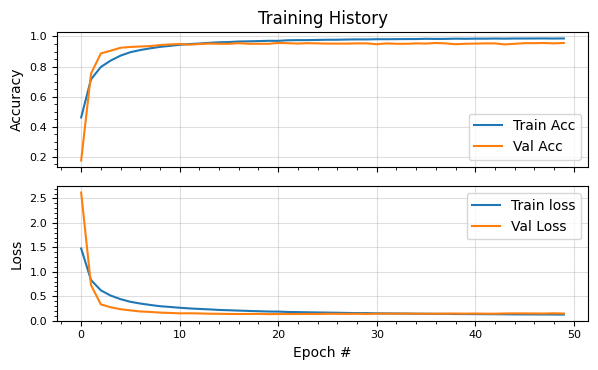

best model was uploaded


In [8]:
# model training
CNN.train_model(sp_train_aug, lab_train_aug,
                n_epochs=50,
                batch_size=132,
                val_data=[sp_val, lab_val])

## CNN evaluation & Comparaison with machine learning models

---

**Important Function/Class used :** 
   - ``predict_classes`` : Predicts class(es) for the input spectrum(s).    
   - ``clf_report`` :  Returns a classification report generated from a given set of spectra.
   - ``cf_matrix`` : Returns a confusion matrix (built with scikit-learn) generated on a given set of spectra.
   - ``SpectroRF`` : Random forest classification model.
   - ``SpectroSVM`` : Support Vector Machine classification model.
   - ``SpectroLDA`` : Linear Discriminant Analysis model.
   
**Comments** :

- The CNN is the only model with which we apply data augmentation as it requires more data to be accurate and to avoid overfitting

- 

- Write ``help(name of the function or the class)`` to get more information, namely on the parameters. 

### CNN 

              precision    recall  f1-score   support

       Blank     0.8504    0.9558    0.9000       113
          CA     0.9510    0.8818    0.9151       110
         DCA     0.9478    0.9561    0.9520       114
       GCDCA     0.9350    0.9504    0.9426       121
         LCA     1.0000    0.9362    0.9670       141
       TCDCA     1.0000    1.0000    1.0000       121

    accuracy                         0.9472       720
   macro avg     0.9474    0.9467    0.9461       720
weighted avg     0.9498    0.9472    0.9476       720



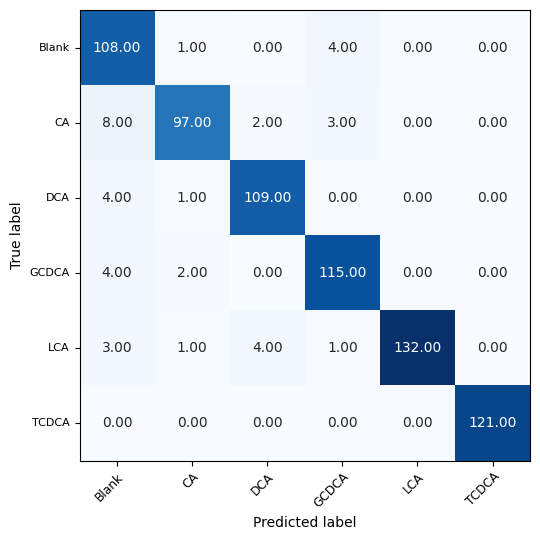

In [9]:
# Predict the labels for sp_test
lab_pred = CNN.predict_classes(sp_test, return_integers=False)

# Return the classification report and display the confusion matrix
clf = validation_metrics.clf_report(lab_test, lab_pred,class_names=classnames)
cf_mat = validation_metrics.cf_matrix(lab_test, lab_pred, normalize=None, class_names=classnames)

### Random Forest

              precision    recall  f1-score   support

       Blank     0.8898    0.9292    0.9091       113
          CA     0.8899    0.8818    0.8858       110
         DCA     0.8015    0.9561    0.8720       114
       GCDCA     0.8793    0.8430    0.8608       121
         LCA     0.9661    0.8085    0.8803       141
       TCDCA     0.9837    1.0000    0.9918       121

    accuracy                         0.9000       720
   macro avg     0.9017    0.9031    0.9000       720
weighted avg     0.9048    0.9000    0.8998       720



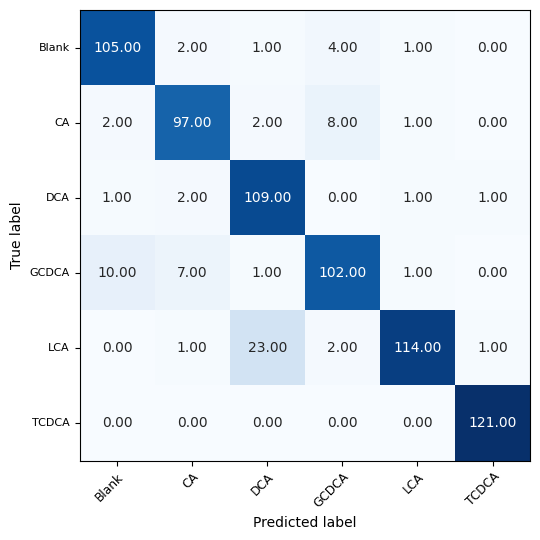

In [10]:
# Creating instance of SpectroRF
RF = SpectroRF(n_trees=500)

# Model training
RF.train_model(sp_train, lab_train)

# Predict the labels for sp_test
lab_pred_rf = RF.predict_classes(sp_test)

# Return the classification report and display the confusion matrix
clf = validation_metrics.clf_report(lab_test, lab_pred_rf,class_names=classnames)
cf_mat = validation_metrics.cf_matrix(lab_test, lab_pred_rf, normalize=None, class_names=classnames)

### Suport Vector Machine

              precision    recall  f1-score   support

       Blank     0.9558    0.9558    0.9558       113
          CA     0.8596    0.8909    0.8750       110
         DCA     0.8438    0.9474    0.8926       114
       GCDCA     0.8672    0.9174    0.8916       121
         LCA     0.9828    0.8085    0.8872       141
       TCDCA     1.0000    1.0000    1.0000       121

    accuracy                         0.9167       720
   macro avg     0.9182    0.9200    0.9170       720
weighted avg     0.9212    0.9167    0.9166       720



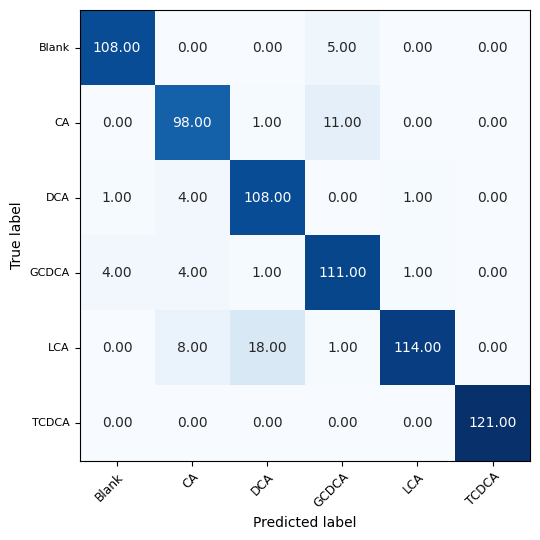

In [15]:
# Creating instance of SpectroSVM
SVM = SpectroSVM(c=1.0, kernel='rbf', gamma='scale')

# Model training
SVM.train_model(sp_train, lab_train)

# Predict the labels for sp_test
lab_pred_svm = SVM.predict_classes(sp_test)

# Return the classification report and display the confusion matrix
clf = validation_metrics.clf_report(lab_test, lab_pred_svm,class_names=classnames)
cf_mat = validation_metrics.cf_matrix(lab_test, lab_pred_svm, normalize=None, class_names=classnames)

### Linear Discriminant Analysis

              precision    recall  f1-score   support

       Blank     0.9375    0.9292    0.9333       113
          CA     0.8909    0.8909    0.8909       110
         DCA     0.9160    0.9561    0.9356       114
       GCDCA     0.8594    0.9091    0.8835       121
         LCA     0.9692    0.8936    0.9299       141
       TCDCA     1.0000    1.0000    1.0000       121

    accuracy                         0.9292       720
   macro avg     0.9288    0.9298    0.9289       720
weighted avg     0.9306    0.9292    0.9294       720



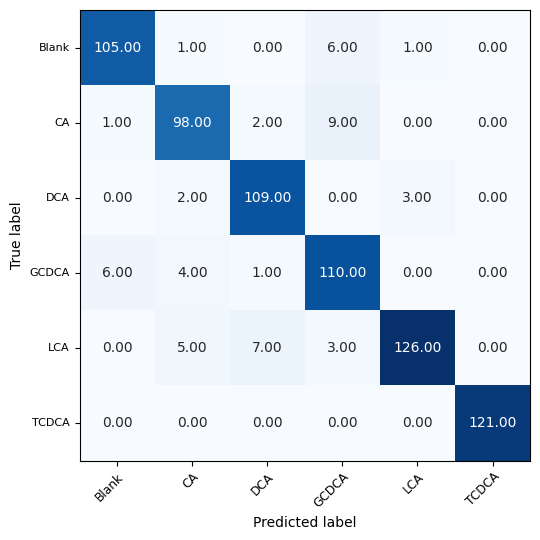

In [16]:
# Creating instance of SpectroLDA
LDA = SpectroLDA()

# Model training
LDA.train_model(sp_train, lab_train)

# Predict the labels for sp_test
lab_pred_lda = LDA.predict_classes(sp_test)

# Return the classification report and display the confusion matrix
clf = validation_metrics.clf_report(lab_test, lab_pred_lda,class_names=classnames)
cf_mat = validation_metrics.cf_matrix(lab_test, lab_pred_lda, normalize=None, class_names=classnames)